In [1]:
# %env MUJOCO_GL=glfw

In [2]:
# %matplotlib widget

In [3]:
import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".50"  #restrict JAX to 50% of available GPU RAM; useful for loading MyoSuite and UitB policies simultaneously

In [4]:
import os
import functools
from etils import epath
from IPython.display import HTML

import mujoco
from mujoco import mjx

import jax
from jax import numpy as jp

from brax import envs
from brax.io import model
from brax.training.agents.ppo import networks as ppo_networks
from brax.training.acme import running_statistics
from brax.v1 import envs as envs_v1

import numpy as np
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import pandas as pd
import mediapy as media

In [5]:
def display_video(frames, framerate=30):
    anim = _create_animation(frames, framerate=framerate)
    return HTML(anim.to_html5_video())

def _create_animation(frames, framerate=30):
    height, width, _ = frames[0].shape
    dpi = 70
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg')  # Switch to headless 'Agg' to inhibit figure rendering.
    fig, ax = plt.subplots(1, 1, figsize=(width / dpi, height / dpi), dpi=dpi)
    matplotlib.use(orig_backend)  # Switch back to the original backend.
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0])
    def update(frame):
        im.set_data(frame)
        return [im]
    interval = 1000/framerate
    return animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                   interval=interval, blit=True, repeat=False)

def setup_env(env, seed=123, 
              num_envs=1, episode_length=800,
              action_repeat=1, wrap_env=True, wrap_env_fn=None, randomization_fn=None):
    key = jax.random.PRNGKey(seed)
    global_key, local_key = jax.random.split(key)
    del key
    
    process_count = jax.process_count()
    process_id = jax.process_index()
    local_device_count = jax.local_device_count()
    local_devices_to_use = local_device_count
    local_key = jax.random.fold_in(local_key, process_id)
    local_key, key_env, eval_key = jax.random.split(local_key, 3)
    del global_key

    if wrap_env:
        v_randomization_fn = None
        if randomization_fn is not None:
          randomization_batch_size = num_envs // local_device_count
          # all devices gets the same randomization rng
          randomization_rng = jax.random.split(key_env, randomization_batch_size)
          v_randomization_fn = functools.partial(
              randomization_fn, rng=randomization_rng
          )
        if wrap_env_fn is not None:
          wrap_for_training = wrap_env_fn
        elif isinstance(env, envs.Env):
          wrap_for_training = envs.training.wrap
        else:
          wrap_for_training = envs_v1.wrappers.wrap_for_training
        env = wrap_for_training(
            env,
            episode_length=episode_length,
            action_repeat=action_repeat,
            randomization_fn=v_randomization_fn,
        )  # pytype: disable=wrong-keyword-args

    reset_fn = jax.jit(jax.vmap(env.reset))
    key_envs = jax.random.split(key_env, num_envs // process_count)
    key_envs = jp.reshape(
        key_envs, (local_devices_to_use, -1) + key_envs.shape[1:]
    )
    env_state = reset_fn(key_envs)
    # Discard the batch axes over devices and envs.
    obs_shape = jax.tree_util.tree_map(lambda x: x.shape[2:], env_state.obs)

    normalize_observations = True
    network_factory = ppo_networks.make_ppo_networks

    normalize = lambda x, y: x
    if normalize_observations:
        normalize = running_statistics.normalize
    ppo_network = network_factory(
        obs_shape, env.action_size, preprocess_observations_fn=normalize
    )
    make_policy = ppo_networks.make_inference_fn(ppo_network)

    return make_policy


### Load simulated user

In [6]:
## LOAD ENV

env_name = 'mobl_arms_index_llc_eepos_adaptive_mjx-v0'
from myosuite.envs.myo.myouser.llc_eepos_adaptive_mjx_v0 import LLCEEPosAdaptiveEnvMJXV0, LLCEEPosAdaptiveDirectCtrlEnvMJXV0
envs.register_environment(env_name, LLCEEPosAdaptiveEnvMJXV0)

model_path = 'simhive/uitb_sim/mobl_arms_index_llc_eepos_pointing.xml'
path = (epath.Path(epath.resource_path('myosuite')) / (model_path)).as_posix()
#TODO: load kwargs from config file/registration
kwargs = {
        'frame_skip': 25,  #use 5 for evaluation?
        'target_pos_range': {'fingertip': jp.array([[0.225, -0.3, -0.3], [0.35, 0.1, 0.4]]),},
        'target_radius_range': {'fingertip': jp.array([0.01, 0.15]),},
        'ref_site': 'humphant',
        'adaptive_task': True,
        # 'init_target_area_width_scale': 0,
        # 'adaptive_increase_success_rate': 0.6,
        # 'adaptive_decrease_success_rate': 0.3,
        # 'adaptive_change_step_size': 0.05,
        # 'adaptive_change_min_trials': 50,
        'success_log_buffer_length': 500,
        # 'normalize_act': True,
        'reset_type': 'range_uniform',
        # 'max_trials': 10
    }
env = envs.get_environment(env_name, model_path=path, auto_reset=False, **kwargs)

MyoSuite:> Registering Myo Envs
MyoSuite:> Registering MyoUser Envs


In [7]:
## LOAD TRAINED POLICY

make_inference_fn = setup_env(env)

cwd = os.getcwd()  #os.path.dirname(os.path.abspath(__file__))

params = model.load_params(cwd + '/ArmReachParams')
inference_fn = make_inference_fn(params)
jit_inference_fn = jax.jit(inference_fn)

jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)

In [8]:
## LOAD ENV [UitB -- only required to load UitB policy]
import uitb

simulator_folder = "../simulators/mobl_arms_index_llc_eepos_pointing_adaptive_v101"
path = (epath.Path(epath.resource_path('uitb')) / (simulator_folder)).as_posix()
env_uitb = uitb.Simulator.get(path, run_parameters={"action_sample_freq": 100, "evaluate": True}, render_mode="rgb_array_list", render_show_depths=False, use_cloned=False)

In [9]:
## LOAD TRAINED POLICY [UitB]

from stable_baselines3 import PPO

policy_path = os.path.join("../simulators/mobl_arms_index_llc_eepos_pointing_adaptive_v101/checkpoints", "model_200000000_steps")
path = (epath.Path(epath.resource_path('uitb')) / (policy_path)).as_posix()
policy = PPO.load(path)

/home/florian/.local/lib/python3.10/site-packages/stable_baselines3/common/save_util.py:166: UserWarning: Could not deserialize object learning_rate. Consider using `custom_objects` argument to replace this object.
Exception: code expected at most 16 arguments, got 18
  warnings.warn(
/home/florian/.local/lib/python3.10/site-packages/stable_baselines3/common/save_util.py:166: UserWarning: Could not deserialize object clip_range. Consider using `custom_objects` argument to replace this object.
Exception: code expected at most 16 arguments, got 18
  warnings.warn(
/home/florian/.local/lib/python3.10/site-packages/stable_baselines3/common/save_util.py:166: UserWarning: Could not deserialize object lr_schedule. Consider using `custom_objects` argument to replace this object.
Exception: code expected at most 16 arguments, got 18
  warnings.warn(


In [10]:
# UitB: {'proprioception': np.concatenate([qpos, qvel, qacc, ee_position, act, motor_act]), 'stateful_information': np.concatenate([target_pos, target_radius])}
# MyoUser: ['qpos', 'qvel', 'qacc', 'ee_pos', 'act', 'motor_act', 'target_pos', 'target_radius']

In [ ]:
# ## MyoUser --> UitB target position transform (only for setting target pos; internally, same MuJoCo coordinates are used)

# #env.generate_target_pos(rng, 1.) 
# #jp.array([ 0.44252305, -0.20042047,  1.25676664])
# myouser2uitb = lambda target_pos: target_pos - env.target_coordinates_origin - jp.array([0.225, -0.1, 0.05])  #last subtracting is due to 'target_origin_rel' target area offset only used in UitB
# myouser2uitb(target_pos)

Array([0.01007805, 0.16957953, 0.16376664], dtype=float64)

In [12]:
## RUN SIMULATION ENVIRONMENT

# Define number of episodes
n_trials = 1

# Define/override maximum steps per episode 
max_episode_steps = 100  #np.inf   #500

# Create empty list which all frames of the forward simulation will be appended to
frame_collection = []

# Create empty list which all rewards of the forward simulation will be appended to
reward_collection = []

# Create empty list which all success flags of the forward simulation will be appended to
success_collection = []

# Create empty lists to store all MuJoCo data states and info dicts
rollout = []
rollout_info = []
rollout_pointer = 0

for trial in range(n_trials):
    print(f"+++ Trial #{trial+1}/{n_trials} +++")

    # Reset with some seed for debugging purposes
    env.max_trials = 1

    rng = jax.random.PRNGKey(trial)
    # target_pos = jp.array([ 0.20886687, -0.34792655,  1.1696696 ])
    state = jit_reset(rng,) # target_pos=target_pos)
    rollout += [state.pipeline_state]
    rollout_info += [state.info]
    reward_collection += [np.nan]  #no reward available at initial state

    # # # Manually update target position
    # # env.task._spawn_target(env._model, env._data, new_position=target_position, new_radius=target_radius)
    state.info['target_pos'] = env.generate_target_pos(rng, 1.)  #state.info['target_area_dynamic_width_scale'])
    # state.info['target_pos'] = jp.array([ 0.20886687, -0.34792655,  1.1696696 ])
    target_pos = state.info['target_pos'].copy()

    terminated = False
    truncated = False
    success = False
    step = 0

    while not (terminated or truncated):  #for step in range(num_steps):
        step += 1
        print(f"Step {step}")

        # # A: choose random action from action space
        # action = env.action_space.sample()
        
        # # B: get actions from MyoUser policy
        # act_rng, rng = jax.random.split(rng)
        # action, _ = jit_inference_fn(state.obs, act_rng)

        # C: get actions from UitB policy
        obs_dict_uitb = {'proprioception': state.obs[:-4], 'stateful_information': state.obs[-4:]}
        action, _ = policy.predict(obs_dict_uitb, deterministic=True)
        action = action.astype(jp.float64)
        
        # apply the action
        state = jit_step(state, action)
        # print(state.pipeline_state.site_xpos[mujoco.mj_name2id(env.sys.mj_model, mujoco.mjtObj.mjOBJ_SITE, "fingertip_target")]) #sites are not updated during forward simulation, instead obs entries are directly modified (sites updated later by env.render)
        rollout.append(state.pipeline_state)
        rollout_info.append(state.info)

        ## TODO: remove when not needed anymore
        obs_dict = env.get_obs_dict(state.pipeline_state, state.info)
        target_hit = obs_dict["target_success"]  #state.info["steps_inside_target"] >= env.dwell_threshold
        success = success or target_hit
        terminated = obs_dict['task_completed']  #success if env.max_trials else False
        # rwd_dict = env.get_reward_dict(obs_dict)
        # print(step, obs_dict['target_success'], obs_dict['task_completed'], obs_dict['steps_inside_target'], obs_dict['steps_since_last_hit'], obs_dict['trial_idx'])

        if step >= max_episode_steps:
            truncated = True  #truncate from outer loop
        
        # store received reward
        reward_collection.append(state.reward)
        
        # If the epsiode is up, then stop
        if terminated or truncated:
            frame_collection.extend(env.render(rollout[rollout_pointer:], target_pos)) #with render_mode="rgb_array_list", env.render() returns a list of all frames since last call of reset()
            rollout_pointer = len(rollout)
            break

        # if step >= max_episode_steps/2:
        #     env.perception.perception_modules[0]._camera_active = False
        # if step >= 3*max_episode_steps/4:
        #     env.perception.perception_modules[0]._camera_active = True

    # Store whether trial was successful
    success_collection.append(success)

    # Also store remaining frames of unfinished last episode
    frame_collection.extend(env.render(rollout[rollout_pointer:], target_pos))
    rollout_pointer = len(rollout)

# Calculate success rate over n_trials
success_rate = sum(success_collection)/len(success_collection)
print(f"Success rate: {success_rate*100:g}% ({sum(success_collection)}/{len(success_collection)})")

# # Close the env
# env.close()

# # Show all simulated frames
# display_video(frame_collection, framerate=env.fps)
# #display_video_with_rewards(frame_collection, reward_collection, framerate=env.fps)

+++ Trial #1/1 +++
[ 0.21752305 -0.10042047  1.20676664]
Step 1
Step 2
Step 3
Step 4
Step 5
Step 6
Step 7
Step 8
Step 9
Step 10
Step 11
Step 12
Step 13
Step 14
Step 15
Step 16
Step 17
Step 18
Step 19
Step 20
Step 21
Step 22
Success rate: 100% (1/1)


In [13]:
display_video(frame_collection, framerate=np.array(1/env.dt, dtype=float))

In [21]:
n_steps = 100
render_every = 10

####

rng = jax.random.PRNGKey(0)
mj_model = env.sys.mj_model
mj_data = mujoco.MjData(mj_model)

renderer = mujoco.Renderer(mj_model)
ctrl = jp.zeros(mj_model.nu)

images = []
for i in range(n_steps):
  act_rng, rng = jax.random.split(rng)

  obs = env.get_obs_vec(mjx.put_data(mj_model, mj_data))  #, ctrl)
  ctrl, _ = jit_inference_fn(obs, act_rng)

  mj_data.ctrl = ctrl
  for _ in range(env._n_frames):
    mujoco.mj_step(mj_model, mj_data)  # Physics step using MuJoCo mj_step.

  if i % render_every == 0:
    renderer.update_scene(mj_data, camera='side')
    images.append(renderer.render())

media.show_video(images, fps=1.0 / env.dt / render_every)

TypeError: LLCEEPosAdaptiveDirectCtrlEnvMJXV0.get_obs_vec() missing 1 required positional argument: 'info'

In [17]:
def pointing_evaluation(env, policy, target_position, target_radius, n_trials=1, max_episode_steps=np.inf, verbose=0):
    # Create empty list which all frames of the forward simulation will be appended to
    frame_collection = []

    # Create empty list which all rewards of the forward simulation will be appended to
    reward_collection = []

    # Create empty list which all success flags of the forward simulation will be appended to
    success_collection = []

    for trial in range(n_trials):
        if verbose >= 1:
            print(f"Trial #{trial+1}/{n_trials}")

        # Reset with some seed for debugging purposes    
        env.task._max_trials = 1
        obs, info = env.reset()
        reward_collection += [np.nan]  #no reward available at initial state

        # Manually update target position
        env.task._spawn_target(env._model, env._data, new_position=target_position, new_radius=target_radius)

        terminated = False
        truncated = False
        success = False
        step = 0

        while not (terminated or truncated):  #for step in range(num_steps):
            step += 1

            # # choose random action from action space
            # action = env.action_space.sample()
            
            # get actions from policy
            action, _internal_policy_state = policy.predict(obs, deterministic=True)
            
            # apply the action
            obs, reward, terminated, truncated, info = env.step(action)
            success = success or info["target_hit"]

            if step >= max_episode_steps:
                truncated = True  #truncate from outer loop
            
            # store received reward
            reward_collection.append(reward)
            
            # If the epsiode is up, then stop
            if terminated or truncated:
                frame_collection.extend(env.render()) #with render_mode="rgb_array_list", env.render() returns a list of all frames since last call of reset()
                break

            # if step >= max_episode_steps/2:
            #     env.perception.perception_modules[0]._camera_active = False
            # if step >= 3*max_episode_steps/4:
            #     env.perception.perception_modules[0]._camera_active = True

        # Store whether trial was successful
        success_collection.append(success)

        # Also store remaining frames of unfinished last episode
        frame_collection.extend(env.render())

    # Calculate success rate over n_trials
    success_rate = sum(success_collection)/len(success_collection)

    # Close the env
    env.close()

    return success_rate

#### Test/visualise task environment

In [18]:
## Define task parameters

# target_position = np.array([0, -0.3, -0.3])
target_x_normalised = 0.5  #between 0 and 1
target_x = env.task._target_limits_x[0] + target_x_normalised*(env.task._target_limits_x[1] - env.task._target_limits_x[0])

target_y_normalised = 0.2  #between 0 and 1
target_y = env.task._target_limits_y[0] + target_y_normalised*(env.task._target_limits_y[1] - env.task._target_limits_y[0])

target_z_normalised = 0.2  #between 0 and 1
target_z = env.task._target_limits_z[0] + target_z_normalised*(env.task._target_limits_z[1] - env.task._target_limits_z[0])

target_position = np.array([target_x, target_y, target_z])

target_radius_normalised = 0.8  #between 0 and 1
target_radius = env.task._target_radius_limit[0] + target_radius_normalised*(env.task._target_radius_limit[1] - env.task._target_radius_limit[0])


In [19]:
## RUN SIMULATION ENVIRONMENT

# Define number of episodes
n_trials = 5

# Define/override maximum steps per episode 
max_episode_steps = np.inf   #500

# Create empty list which all frames of the forward simulation will be appended to
frame_collection = []

# Create empty list which all rewards of the forward simulation will be appended to
reward_collection = []

# Create empty list which all success flags of the forward simulation will be appended to
success_collection = []

for trial in range(n_trials):

    # Reset with some seed for debugging purposes
    env.task._max_trials = 1
    obs, info = env.reset()
    reward_collection += [np.nan]  #no reward available at initial state

    # Manually update target position
    env.task._spawn_target(env._model, env._data, new_position=target_position, new_radius=target_radius)

    terminated = False
    truncated = False
    success = False
    step = 0

    while not (terminated or truncated):  #for step in range(num_steps):
        step += 1

        # # choose random action from action space
        # action = env.action_space.sample()
        
        # get actions from policy
        action, _internal_policy_state = policy.predict(obs, deterministic=True)
        
        # apply the action
        obs, reward, terminated, truncated, info = env.step(action)
        success = success or info["target_hit"]

        if step >= max_episode_steps:
            truncated = True  #truncate from outer loop
        
        # store received reward
        reward_collection.append(reward)
        
        # If the epsiode is up, then stop
        if terminated or truncated:
            frame_collection.extend(env.render()) #with render_mode="rgb_array_list", env.render() returns a list of all frames since last call of reset()
            break

        # if step >= max_episode_steps/2:
        #     env.perception.perception_modules[0]._camera_active = False
        # if step >= 3*max_episode_steps/4:
        #     env.perception.perception_modules[0]._camera_active = True

    # Store whether trial was successful
    success_collection.append(success)

    # Also store remaining frames of unfinished last episode
    frame_collection.extend(env.render())

# Calculate success rate over n_trials
success_rate = sum(success_collection)/len(success_collection)
print(f"Success rate: {success_rate*100:g}% ({sum(success_collection)}/{len(success_collection)})")

# Close the env
env.close()

# # Show all simulated frames
# display_video(frame_collection, framerate=env.fps)
# #display_video_with_rewards(frame_collection, reward_collection, framerate=env.fps)

Success rate: 100% (5/5)


In [ ]:
display_video(frame_collection, framerate=env.fps)

#### Iterate over task parameters

In [59]:
## Modify task parameters

n_trials = 5

# target_position = np.array([0, -0.3, -0.3])

target_x_normalised = 0.5  #between 0 and 1
target_x = env.task._target_limits_x[0] + target_x_normalised*(env.task._target_limits_x[1] - env.task._target_limits_x[0])

target_y_normalised = 0.5  #between 0 and 1
target_y = env.task._target_limits_y[0] + target_y_normalised*(env.task._target_limits_y[1] - env.task._target_limits_y[0])

target_z_normalised = 0.5  #between 0 and 1
target_z = env.task._target_limits_z[0] + target_z_normalised*(env.task._target_limits_z[1] - env.task._target_limits_z[0])

target_position = np.array([target_x, target_y, target_z])

target_radius_normalised = 1  #between 0 and 1
target_radius = env.task._target_radius_limit[0] + target_radius_normalised*(env.task._target_radius_limit[1] - env.task._target_radius_limit[0])

success_rate = pointing_evaluation(env, policy, target_position=target_position, target_radius=target_radius, n_trials=n_trials)

In [ ]:
## Iterate over task parameters

n_trials = 5

rows_list = []
# filename_log = "pointing_evaluation_data.csv"
filename_log = "pointing_evaluation_data__LLC_EEPOS_500000000.csv"

with open(filename_log, "a") as f:
    # f.write(",target_y,target_z,target_radius,success_rate\n")

    for target_radius_normalised in np.linspace(0, 1, 6):
        for target_x_normalised in np.linspace(0, 1, 6):
            for target_y_normalised in np.linspace(0, 1, 6):
                for target_z_normalised in np.linspace(0, 1, 6):
                    target_radius = env.task._target_radius_limit[0] + target_radius_normalised*(env.task._target_radius_limit[1] - env.task._target_radius_limit[0])
                    target_x = env.task._target_limits_x[0] + target_x_normalised*(env.task._target_limits_x[1] - env.task._target_limits_x[0])
                    target_y = env.task._target_limits_y[0] + target_y_normalised*(env.task._target_limits_y[1] - env.task._target_limits_y[0])
                    target_z = env.task._target_limits_z[0] + target_z_normalised*(env.task._target_limits_z[1] - env.task._target_limits_z[0])

                    target_position = np.array([target_x, target_y, target_z])
                    success_rate = pointing_evaluation(env, policy, target_position=target_position, target_radius=target_radius, n_trials=n_trials)

                    rows_list += [{"target_y": target_position[0], "target_y": target_position[1], "target_z": target_position[2], "target_radius": target_radius, "success_rate": success_rate}]
                    f.write(",".join([f"{i:.5g}" for i in [0, target_position[1], target_position[2], target_radius, success_rate]])+"\n")
                    print(f"({target_position[1]}, {target_position[2]}, {target_radius}): {success_rate}")

df = pd.DataFrame(rows_list)
df

(-0.2, -0.35, 0.01): 0.0
(-0.2, -0.21, 0.01): 0.0
(-0.2, -0.07, 0.01): 0.0
(-0.2, 0.07000000000000006, 0.01): 0.0
(-0.2, 0.20999999999999996, 0.01): 0.0
(-0.2, 0.35, 0.01): 0.0
(-0.12, -0.35, 0.01): 0.0
(-0.12, -0.21, 0.01): 0.0
(-0.12, -0.07, 0.01): 0.0
(-0.12, 0.07000000000000006, 0.01): 0.0
(-0.12, 0.20999999999999996, 0.01): 0.0
(-0.12, 0.35, 0.01): 0.0
(-0.03999999999999998, -0.35, 0.01): 0.0
(-0.03999999999999998, -0.21, 0.01): 0.0
(-0.03999999999999998, -0.07, 0.01): 0.0
(-0.03999999999999998, 0.07000000000000006, 0.01): 0.0
(-0.03999999999999998, 0.20999999999999996, 0.01): 0.0
(-0.03999999999999998, 0.35, 0.01): 0.0
(0.040000000000000036, -0.35, 0.01): 0.0
(0.040000000000000036, -0.21, 0.01): 0.0
(0.040000000000000036, -0.07, 0.01): 0.0
(0.040000000000000036, 0.07000000000000006, 0.01): 0.0
(0.040000000000000036, 0.20999999999999996, 0.01): 0.0
(0.040000000000000036, 0.35, 0.01): 0.0
(0.12000000000000005, -0.35, 0.01): 0.0
(0.12000000000000005, -0.21, 0.01): 0.0
(0.12000000000

,target_y,target_z,target_radius,success_rate
0,-0.2,-0.35,0.01,0.0
1,-0.2,-0.21,0.01,0.0
2,-0.2,-0.07,0.01,0.0
3,-0.2,0.07,0.01,0.0
4,-0.2,0.21,0.01,0.0
...,...,...,...,...
1291,0.2,-0.21,0.15,0.8
1292,0.2,-0.07,0.15,0.2
1293,0.2,0.07,0.15,1.0
1294,0.2,0.21,0.15,0.8


#### Plot success rates for different positions and radii

In [81]:
target_origin = np.array([0.532445, -0.27, 0.993])  #env.task._target_origin
target_origin_rel = np.array([0.55, -0.1, 0])  #env.task._target_origin - getattr(env._data, env.task._shoulder[0])(env.task._shoulder[1]).xpos
shoulder_ref_pos = target_origin - target_origin_rel  #getattr(env._data, env.task._shoulder[0])(env.task._shoulder[1]).xpos

## mapping from internally used local 2D (y, z) coordinates (with target origin as reference) to local 3D (x, y, z) coordinates (with shoulder as reference)
target_to_global_mapping = lambda xyz: target_origin + np.array([xyz[0], xyz[1], xyz[2]])
target_to_global_mapping_singledim = lambda xoryorz, axis: target_origin[axis] + xoryorz
target_to_shoulder_mapping = lambda xyz: target_origin + np.array([xyz[0], xyz[1], xyz[2]]) - shoulder_ref_pos
target_to_shoulder_mapping_singledim = lambda xoryorz, axis: target_origin[axis] + xoryorz - shoulder_ref_pos[axis]

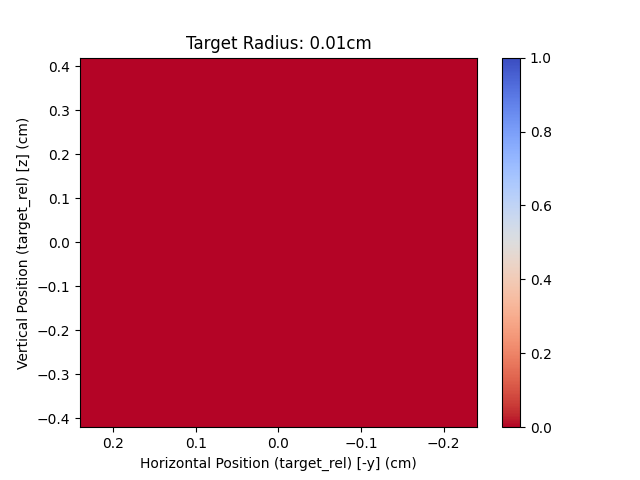

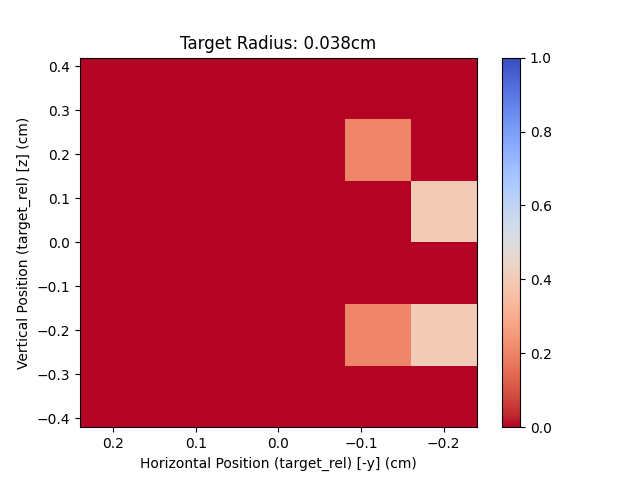

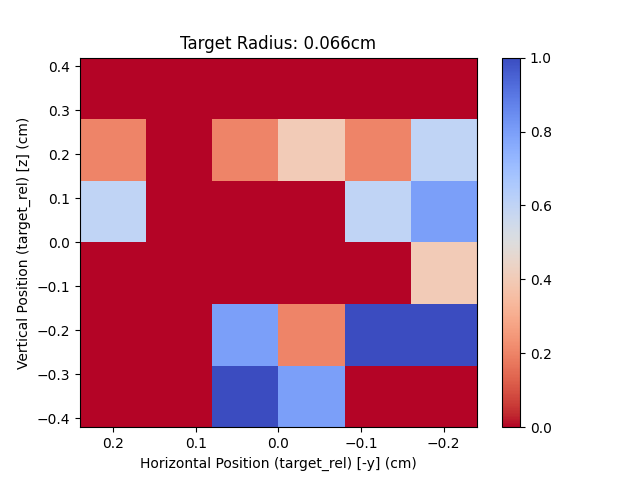

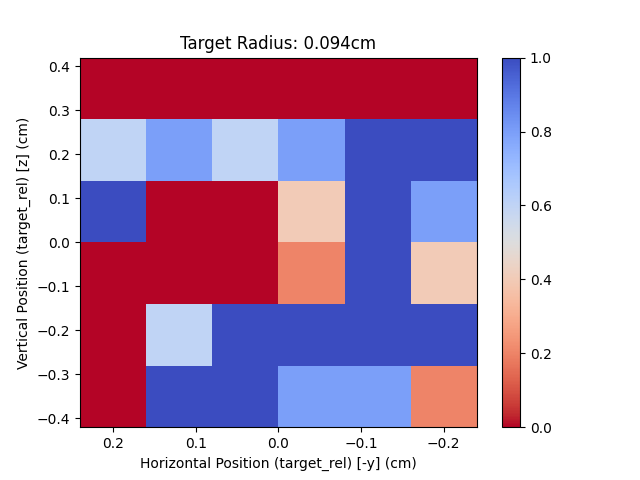

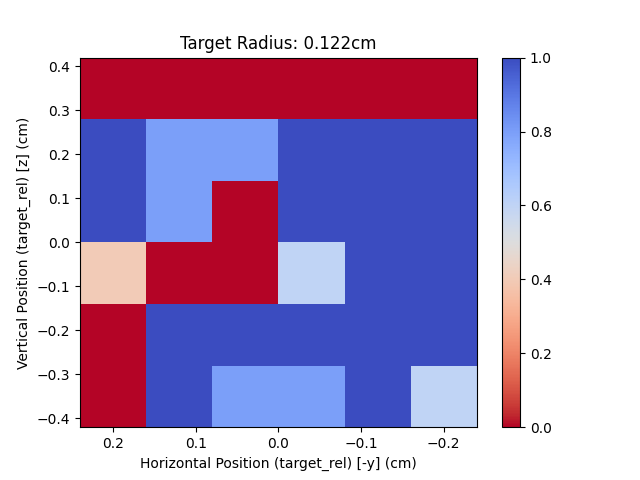

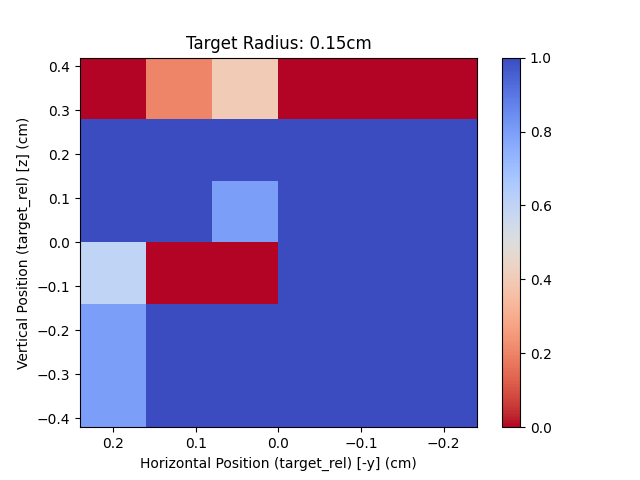

In [22]:
# df = pd.read_csv("pointing_evaluation_data_10x10x10.csv", index_col=0).drop_duplicates()
df = pd.read_csv("pointing_evaluation_data__LLC_EEPOS_500000000.csv", index_col=0).drop_duplicates()

_target_x = 0.025

PLOT_SHOULDER_REL_COORDS = False   #whether to plot with x-/y-axis ticks relative to shoulder origin (True) or in global coordinates (False)
PLOT_TARGET_REL_COORDS = True   #whether to plot with x-/y-axis ticks relative to target plane origin (True) or in global coordinate (False)

assert not (PLOT_SHOULDER_REL_COORDS and PLOT_TARGET_REL_COORDS), f"Cannot set both PLOT_SHOULDER_REL_COORDS and PLOT_TARGET_REL_COORDS to True."

for _target_r in df["target_radius"].unique():
    df_sub = df[(df["target_radius"] == _target_r) & (df["target_x"] == _target_x)]
    # df_sub_shoulderref = np.array(list(map(target_to_shoulder_mapping, pd.concat((df_sub["target_y"], df_sub["target_z"]), axis=1).values)))
    # dim_vals = np.unique(df_sub_shoulderref[:, 0]), np.unique(df_sub_shoulderref[:, 1]), np.unique(df_sub_shoulderref[:, 2])
    dim_vals = np.unique(df_sub["target_y"]), np.unique(df_sub["target_z"])
    assert np.prod([len(x) for x in dim_vals]) == len(df_sub), "Data is not available for all cartesian combinations."
    success_rate_mesh = np.array([[df_sub.loc[(df_sub["target_z"] == z) & (df_sub["target_y"] == y), "success_rate"].item() for z in dim_vals[1]] for y in dim_vals[0]])  #each row corresponds to a different horizontal (y) value, each column to a different vertical (z) value

    fig = plt.figure()
    ax = fig.add_subplot()#projection='3d')
    # ax.view_init(elev=30, azim=-150)

    # ax.plot_trisurf(df_sub["target_y"], df_sub["target_z"], df_sub["success_rate"])
    # ax.plot_trisurf(df_sub_shoulderref[:, 1], df_sub_shoulderref[:, 2], df_sub["success_rate"])
    # colorimag = ax.pcolormesh(dim_vals[1], dim_vals[0], success_rate_mesh.T, cmap=plt.matplotlib.cm.coolwarm.reversed(), norm=plt.matplotlib.colors.Normalize(vmin=0, vmax=1))
    if PLOT_SHOULDER_REL_COORDS:
        colorimag = ax.pcolormesh([target_to_shoulder_mapping_singledim(y, 1) for y in dim_vals[0]], [target_to_shoulder_mapping_singledim(z, 2) for z in dim_vals[1]], success_rate_mesh.T, cmap=plt.matplotlib.cm.coolwarm.reversed(), norm=plt.matplotlib.colors.Normalize(vmin=0, vmax=1))
    elif PLOT_TARGET_REL_COORDS:
        colorimag = ax.pcolormesh(dim_vals[0], dim_vals[1], success_rate_mesh.T, cmap=plt.matplotlib.cm.coolwarm.reversed(), norm=plt.matplotlib.colors.Normalize(vmin=0, vmax=1))
    else:
        colorimag = ax.pcolormesh([target_to_global_mapping_singledim(y, 1) for y in dim_vals[0]], [target_to_global_mapping_singledim(z, 2) for z in dim_vals[1]], success_rate_mesh.T, cmap=plt.matplotlib.cm.coolwarm.reversed(), norm=plt.matplotlib.colors.Normalize(vmin=0, vmax=1))
    fig.colorbar(colorimag, ax=ax)
    ax.invert_xaxis()
    _coordinate_system_tag = "shoulder-rel" if PLOT_SHOULDER_REL_COORDS else "target_rel" if PLOT_TARGET_REL_COORDS else "global"
    ax.set_xlabel(f"Horizontal Position ({_coordinate_system_tag}) [-y] (cm)")
    ax.set_ylabel(f"Vertical Position ({_coordinate_system_tag}) [z] (cm)")
    ax.set_title(f"Target Radius: {_target_r}cm")

#### Parallelisation [not working in Jupyter --> run pointing_evaluation_mp.py instead]

In [ ]:
# from multiprocessing import Pool
import multiprocessing
import tqdm

import time

filename_log = "pointing_evaluation_data_TEST.csv"
# with open(filename_log, "w") as f:
#     f.write(",target_y,target_z,target_radius,success_rate")

def task_fixed_radius(target_radius_normalised, env, policy, q, n_trials=5):
    print(f'Running with {target_radius_normalised}!')

    # with open(filename_log, "a") as f:
    for target_y_normalised in np.linspace(0, 1, 11):
        for target_z_normalised in np.linspace(0, 1, 11):
            target_radius = env.task._target_radius_limit[0] + target_radius_normalised*(env.task._target_radius_limit[1] - env.task._target_radius_limit[0])
            target_y = env.task._target_limits_y[0] + target_y_normalised*(env.task._target_limits_y[1] - env.task._target_limits_y[0])
            target_z = env.task._target_limits_z[0] + target_z_normalised*(env.task._target_limits_z[1] - env.task._target_limits_z[0])

            target_position = np.array([0, target_y, target_z])
            success_rate = pointing_evaluation(env, policy, target_position=target_position, target_radius=target_radius, n_trials=n_trials)

            # f.write(",".join([f"{i:.5g}" for i in [0, target_position[1], target_position[2], target_radius, success_rate]])+"\n")
            q.put(",".join([f"{i:.5g}" for i in [0, target_position[1], target_position[2], target_radius, success_rate]])+"\n")
            print(f"({target_position[1]}, {target_position[2]}, {target_radius}): {success_rate}")

def listener(q):  #see https://stackoverflow.com/a/13530258
    '''listens for messages on the q, writes to file. '''

    with open(filename_log, 'w') as f:
        while 1:
            m = q.get()
            if m == 'kill':
                f.write('killed')
                break
            f.write(str(m) + '\n')
            f.flush()

def run_parallelisation():  #see https://stackoverflow.com/a/13530258
    #must use Manager queue here, or will not work
    manager = multiprocessing.Manager()
    q = manager.Queue()    
    pool = multiprocessing.Pool(multiprocessing.cpu_count() + 2)

    #put listener to work first
    watcher = pool.apply_async(listener, (q,))

    #initialisation
    q.put(",target_y,target_z,target_radius,success_rate")

    #fire off workers
    jobs = tqdm.tqdm([pool.apply_async(task_fixed_radius, (target_radius, q)) for target_radius in np.linspace(0, 1, 11)])
    # jobs = []
    # for i in tqdm.tqdm(np.linspace(0, 1, 11)):
    #     job = pool.apply_async(task_fixed_radius, (i, q))
    #     jobs.append(job)

    # collect results from the workers through the pool result queue
    for job in jobs:
        job.get()

    #now we are done, kill the listener
    q.put('kill')
    pool.close()
    pool.join()

if __name__ == '__main__':
    run_parallelisation()
    
# pool = Pool(3) # run 3 tasks at most in parallel
# pool.map(task_fixed_radius, np.linspace(0, 1, 11))

100%|██████████| 11/11 [00:05<00:00,  2.19it/s]
